In [9]:
import pickle
from pathlib import Path
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import os

data_path = Path('C:/Users/rachi/OneDrive/Documentos/Datasets/flickr30k')
feature_path = Path("./results")

In [6]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)


def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])


def pk(actual, predicted, k=10):
    """
    Computes the precision at k.
    This function computes the precision at k between the query image and a list
    of database retrieved images.
    Parameters
    ----------
    actual : int
             The element that has to be predicted
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The precision at k over the input
    """
    if len(predicted) > k:
        predicted = predicted[:k]
    score = 0
    for i in range(len(predicted)):
        if actual == predicted[i]:
            score += 1
    
    return score / len(predicted)

def mpk(actual, predicted, k=10):
    """
    Computes the precision at k.
    This function computes the mean precision at k between a list of query images and a list
    of database retrieved images.
    Parameters
    ----------
    actual : list
             The query elements that have to be predicted
    predicted : list
                A list of predicted elements (order does matter) for each query element
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The precision at k over the input
    """
    pk_list = []
    for i in range(len(actual)):
        score = pk(actual[i], predicted[i], k)
        pk_list.append(score)
    return np.mean(pk_list)

def AP(actual, predicted):
    """
    Computes the precision at k.
    This function computes the average precision precision between the query image and a list
    of database retrieved images.
    Parameters
    ----------
    actual : int
             The element that has to be predicted
    predicted : list
                A list of predicted elements (order does matter)
    Returns
    -------
    score : double
            The Average Precision over the input
    """
    gtp = 0
    ap = 0
    for i in range(len(predicted)):
        a = pk(actual, predicted, i+1)
        if actual == predicted[i]: 
            b = 1
            gtp += 1
        else: 
            b = 0
        c = a*b
        ap += c

    if gtp == 0:
       return 0
    else:
        return ap/gtp

def mAP(actual, predicted):
    """
    Computes the precision at k.
    This function computes the mean Average Precision between the query image and a list
    of database retrieved images.
    Parameters
    ----------
    actual : list
             The query elements that have to be predicted
    predicted : list
                A list of predicted elements (order does matter) for each query element
    Returns
    -------
    score : double
            The mean Average Precision over the input
    """
    ap_list = []
    for i in range(len(actual)):
        ap = AP(actual[i], predicted[i])
        ap_list.append(ap)
    return np.mean(ap_list)

In [7]:
import matplotlib.pyplot as plt

def plot_figures(figures, nrows = 1, ncols=1):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows)
    for ind,title in zip(range(len(figures)), figures):
        axeslist.ravel()[ind].imshow(figures[title], cmap=plt.jet())
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional

In [8]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

# precision recall curve
def plot_prec_rec_curve_multiclass(y_gt, y_pred, labels):
    precision = dict()
    recall = dict()
    aps = []
    for i in range(8):
        ap = average_precision_score(y_gt[:, i], y_pred[:, i])
        aps.append(ap)
        precision[i], recall[i], _ = precision_recall_curve(y_gt[:, i],
                                                            y_pred[:, i])
        plt.plot(recall[i], precision[i], lw=2, label=f'{labels[i]} - {ap:.3f}')
        
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend(loc="best")
    plt.title(f"precision vs. recall curve - mAP {np.mean(aps):.3f}")
    plt.show()

In [38]:
import json


with open(f'{data_path}/train.json') as f:
   train_data = json.load(f)

with open(f'{data_path}/val.json') as f:
   val_data = json.load(f)

with open(f'{data_path}/test.json') as f:
   test_data = json.load(f)

print('Length Train data: {}'.format(len(train_data)))
print('Length Validation data: {}'.format(len(val_data)))
print('Length Test data: {}'.format(len(test_data)))

Length Train data: 29000
Length Validation data: 1014
Length Test data: 1000


### TASK D

In [62]:
with (feature_path / "task_d/all_features_train.pkl").open('rb') as tr, \
        (feature_path / "task_d/all_features_validation.pkl").open('rb') as vl, \
        (feature_path / "task_d/all_features_test.pkl").open('rb') as ts:
    train_features = pickle.load(tr)
    val_features = pickle.load(vl)
    test_features = pickle.load(ts)

In [12]:
train_features.keys()

dict_keys(['txt_features', 'img_features', 'txt_labels', 'img_labels'])

TRAIN DATASET

In [63]:
all_img_features = train_features['img_features']
all_txt_features = train_features['txt_features']
all_img_labels = train_features['img_labels']
all_txt_labels = train_features['txt_labels']
anchor = "image"

In [64]:
knn = KNeighborsClassifier(5, metric="euclidean")

if anchor == "text":
    knn = knn.fit(all_img_features, all_img_labels)
    neighbors = knn.kneighbors(all_txt_features, return_distance=False)
    predictions = all_img_labels[neighbors]

    p1 = mpk(all_txt_labels, predictions, 1)
    p5 = mpk(all_txt_labels, predictions, 5)
    map = mAP(all_txt_labels,predictions)
else:
    knn = knn.fit(all_txt_features, all_txt_labels)
    neighbors = knn.kneighbors(all_img_features, return_distance=False)
    predictions = all_txt_labels[neighbors]

    p1 = mpk(all_img_labels, predictions, 1)
    p5 = mpk(all_img_labels, predictions, 5)
    map = mAP(all_img_labels,predictions)

print('P@1=',p1)
print('P@5=',p5)
print('mAP=',map)

P@1= 0.012862068965517242
P@5= 0.011820689655172417
mAP= 0.026084770114942524


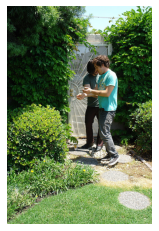

A group of people are running on the sand.
A cashier in asia with some money in her hand.
Two blond people are sitting in a park having a conversation.
A young man looks into the camera while a crowd of people on a busy street pass by.
A child and an adult are walking down the sidewalk.


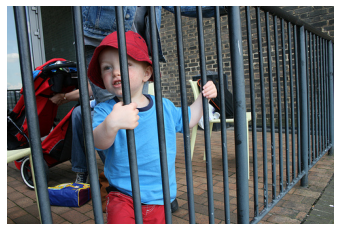

A little boy is leaping in the air onto a water slide.
A man wearing a beanie painting a realistic portrait of a building.
Woman holding a drink with a white bag next to her is sitting on a green sculpture.
Black dog jumps for white ball.
A boy swinging on a swing.


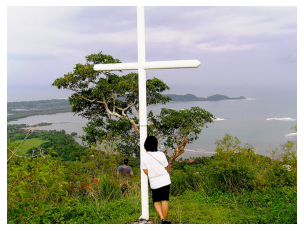

A boy, playing in the water, with the sun upon the horizon.
2 men in white coats are looking on in a Chinese restaurant.
A man stands at the peak of a mountain and has his hand on a monument.
Two mountain climbers sit on a mountain.
People in orange robes line up behind a man wearing sunglasses.


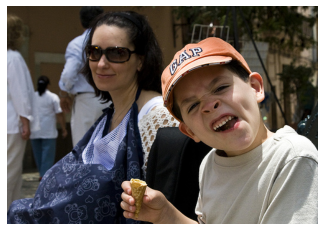

Two onlookers watch a young man as he gets ready to make a hit.
Two elderly women are looking into an ice cream cart.
An awards ceremony with cannons shooting confetti into the air.
A guy riding a bike on a track.
A woman is choosing a perfume


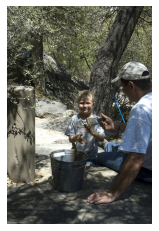

A man being bucked off a bronco at a rodeo.
Team member 39 waiting for the puck to come his way.
A man wearing a backwards blue cap hands something to one man in a line of men.
Two men in jogging attired are running through the woods.
One soccer player is moving the ball while an opposing player prepares to try to take the ball, with another player and an official in the background.


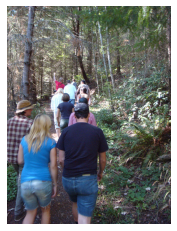

Man on a makeshift scaffolding, fixing a window.
A woman enjoying a sucker is looking out over a railing.
Many people in dark cloths are drinking and talking together.
A group of men, blind folded, walking down the street.
A man and a girl are sitting on a bench.


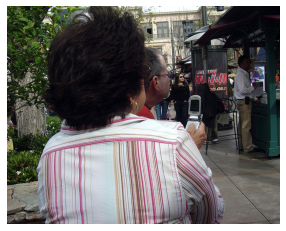

A crowd forms to watch as a man breakdances in the street.
A man in a yellow jumpsuit and blue face mask welds a metal beam.
A man swinging at a tennis ball with a green sign that read findersport.
A man and a young girl relax outside and smile at the camera.
One male is sitting in a marketplace looking aimlessly forward amidst the colorful solid and printed fabrics in the background with a pile of grain in front of him.


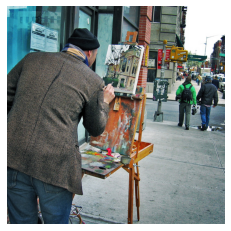

A man and a small boy watch their small, white dog catch a toy in the air.
A rally vehicle creates a dust cloud while racing.
A white dog runs past another dog who is standing beside some patio furniture.
A woman in a suit is standing at a podium while speaking.
Two people walking on the street with lots of bare trees around and snow on the ground.


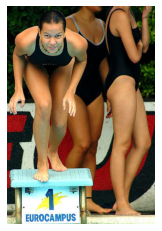

Many people with life jackets on are getting into boats on an icy river.
A guy is playing the bagpipes while standing next to a woman in a light blue outfit with her belly button showing.
A white female wearing a hooded maroon sweater carries an object across a shallow river.
A young Asian girl sits in an orange chair and looks away from the camera.
A man wearing a mask is squatting on the ground.


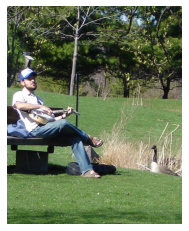

A group of patrons sitting in green lounge chairs along a waterway, one of them has a black jacket across her chair, and is looking out at the water.
Two Black women are walking under a covered structure.
A group of friends around a fire protected with a metallic mesh.
An oriental girl walking in front of water.
A dark complexioned man is shaving the hairs off his head


In [66]:
from PIL import Image
dataset_path = data_path / 'imgs'
query_images = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900]
img_out = "./results/task_d/retrieval"
for index in query_images:
    img_info = train_data[index]
    filename = img_info['filename']
    img= Image.open(dataset_path / filename)
    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()
    for i in range(5):
        j = neighbors[index][i]
        img_id = j//5
        text_id = j%5
        text = train_data[img_id]['sentences'][text_id]['raw']
        print(text)

VALIDATION DATASET

In [59]:
all_img_features = val_features['img_features']
all_txt_features = val_features['txt_features']
all_img_labels = val_features['img_labels']
all_txt_labels = val_features['txt_labels']
anchor = "image"

In [60]:
knn = KNeighborsClassifier(5, metric="euclidean")

if anchor == "text":
    knn = knn.fit(all_img_features, all_img_labels)
    neighbors = knn.kneighbors(all_txt_features, return_distance=False)
    predictions = all_img_labels[neighbors]

    p1 = mpk(all_txt_labels, predictions, 1)
    p5 = mpk(all_txt_labels, predictions, 5)
    map = mAP(all_txt_labels,predictions)
else:
    knn = knn.fit(all_txt_features, all_txt_labels)
    neighbors = knn.kneighbors(all_img_features, return_distance=False)
    predictions = all_txt_labels[neighbors]
    
    p1 = mpk(all_img_labels, predictions, 1)
    p5 = mpk(all_img_labels, predictions, 5)
    map = mAP(all_img_labels,predictions)

print('P@1=',p1)
print('P@5=',p5)
print('mAP=',map)

P@1= 0.1222879684418146
P@5= 0.10019723865877711
mAP= 0.1819293776024545


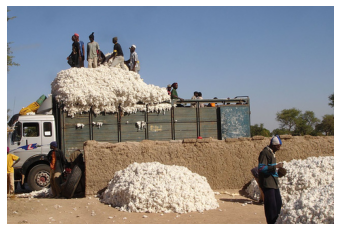

People with camping equipment on rocky ground.
Workers working in the mud and sand.
Three guys are jumping on some grass and making funny faces, you can see their shadows on the ground.
Three cold men set down their supplies in a ditch.
A constructions site on the side of the mountain with a bulldozer digging in the ground that is all dirt


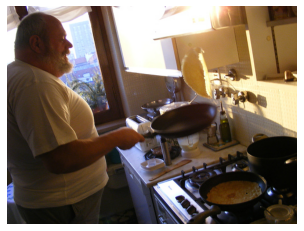

Three food industry workers share a laugh.
A man is mixing something in a large, round pan while several people are around him.
A man in a white shirt is making shish kabob.
A somewhat chubby man making hand gestures with a other man at the sink looking at him.
Two men in coat stand at a table with beakers and alcohol bottles.


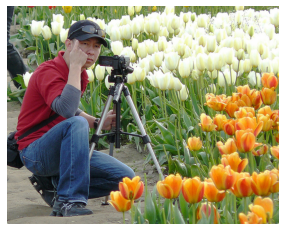

A man in an orange draped outfit raking leaves.
A gentleman selling banana's and grapes.
A person in a straw hat is sitting in weeds.
A man holding a shovel above his head is posing in front of a campfire.
A man kneels down near a large balloon in an open field.


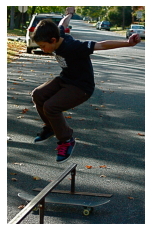

Man attempts skateboard trick in tree-lined skate park.
A boy is doing a stunt with his skateboard.
A male teenager doing a trick in a skate park on a skateboard.
A teen performing a bike trick at a skate park.
A boy jumping a rail on his skateboard.


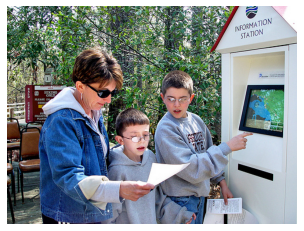

A woman in a sky-blue shirt faces an older man wearing a navy cap.
A man with a white shirt and a woman with a white shirt are talking on their phones.
A young man gives another young man advise on sex and dating.
A man wearing a black jacket and white shirt is talking to a woman at a bar.
Two African American men laughing with aprons on, while a third man wearing a chef jacket is on a cellular phone.


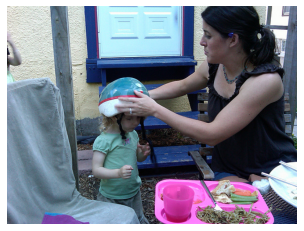

An Asian young woman is working with flower while surrounding by her peers.
Two girls play with their food for the camera.
Two young girls having fun while eating.
Several girls are playing with flour.
Two girls enjoying and sharing their ideas.


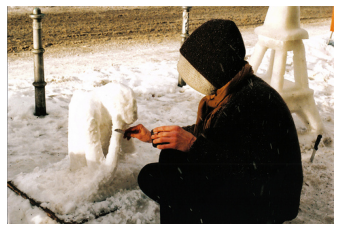

A boy dressed in a dark shirt carries a blue bag over his shoulder and a green pail.
A male in a black shirt and brown cargo pants holding a shovel above his head.
A man has a pan and what looks like a block of dirt.
An old man holding a small hatchet.
A woman is sanding a porch with an electric sander.


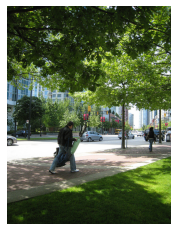

A young couple kissing on a park bench.
Couple is making out on a park bench in public.
A couple sits on a bench talking, while a woman walks a dog in the background.
Here is a picture of a woman and her husband and child taking a stroll by the parking lot.
A man and woman are having a conversation on a park bench.


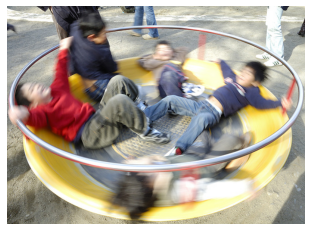

Two asian children grab hands while in a piece of playground equipment.
Two young Asian children are playing on playground equipment.
Little boy juggling orange balls in the park with a playground behind him.
Young children playing on a stoop with a bubble maker.
Three young children stand around a blue and white barrel.


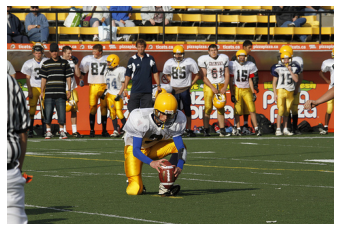

Ballplayers in blue and white uniforms are on the field playing baseball.
A child slid home as all the other baseball players looked on.
A soccer team wearing light blue gets in a huddle during a match.
Three men are running in a track and field race involving hurdles.
The marathon runners draw the race to a close as their supporters Cheer!


In [61]:
from PIL import Image
dataset_path = data_path / 'imgs'
query_images = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900]
img_out = "./results/task_d/retrieval"
for index in query_images:
    img_info = val_data[index]
    filename = img_info['filename']
    img= Image.open(dataset_path / filename)
    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()
    for i in range(5):
        j = neighbors[index][i]
        img_id = j//5
        text_id = j%5
        text = val_data[img_id]['sentences'][text_id]['raw']
        print(text)

TEST DATASET

In [24]:
all_img_features = test_features['img_features']
all_txt_features = test_features['txt_features']
all_img_labels = test_features['img_labels']
all_txt_labels = test_features['txt_labels']
anchor = "image"

In [41]:
knn = KNeighborsClassifier(5, metric="euclidean")

if anchor == "text":
    knn = knn.fit(all_img_features, all_img_labels)
    neighbors = knn.kneighbors(all_txt_features, return_distance=False)
    predictions = all_img_labels[neighbors]

    p1 = mpk(all_txt_labels, predictions, 1)
    p5 = mpk(all_txt_labels, predictions, 5)
    map = mAP(all_txt_labels,predictions)
else:
    knn = knn.fit(all_txt_features, all_txt_labels)
    neighbors = knn.kneighbors(all_img_features, return_distance=False)
    predictions = all_txt_labels[neighbors]

    p1 = mpk(all_img_labels, predictions, 1)
    p5 = mpk(all_img_labels, predictions, 5)
    map = mAP(all_img_labels,predictions)

print('P@1=',p1)
print('P@5=',p5)
print('mAP=',map)

P@1= 0.109
P@5= 0.0984
mAP= 0.17606111111111114


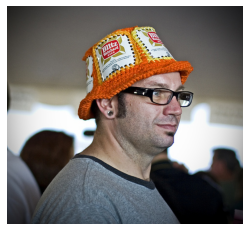

The man with pierced ears is wearing glasses and an orange hat.
A man in an orange hat starring at something.
A young child wearing a mask at Ivars.
A man wears an orange hat and glasses.
A man wearing a helmet and sunglasses smiles.


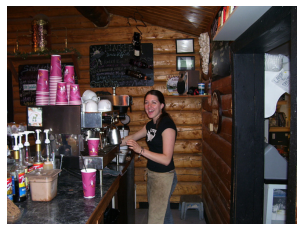

Four young teens having fun at a cookout.
Several ladies gathered around a table engaged in an electronics project
A woman standing with 3 other people in a store with two tables, some shelves with coffee and tea for sale, and a refrigerated drink case.
Several adults are filling their cups and a drink machine.
Two guys getting a drink at a store counter.


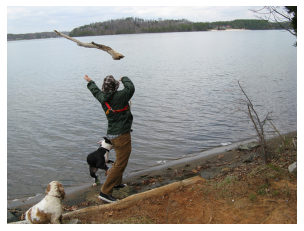

A man holds his dog near a pond.
A man is standing at edge of a pond, with two dogs and is throwing a branch is water.
A dog walks on a log across a small river.
A young boy plays in the water with the mountains in the background.
A man is throwing a big stick into the water so his two dogs and go fetch it.


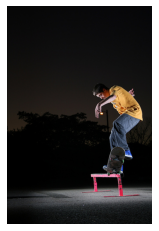

Man, skateboarding
A young adult is doing a back flip on a trampoline near a lake.
A young man hits a spectacular pose on a rail midair on his skateboard.
A man doing a trick on skateboard
A young boy is either jumping on a trampoline or skateboarding and he is serious about it on a beautiful summer day.


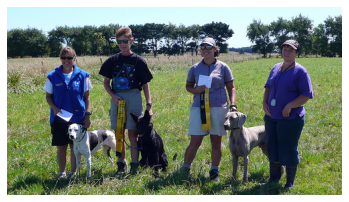

Four people holding three dogs in a field.
Four people stand with their dogs in a field.
These four people are standing outdoors, with 3 dogs.
A group of people stands by their dogs in a field.
The woman and three dogs are in a field.


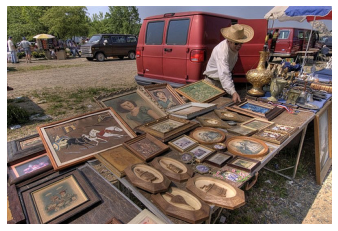

An old black man sitting in front of a white and blue shack.
A man is leaning over and pulling something out of a bag.
A man trimming a palm tree inside a patio-type cafe'.
A man in heavy clothing with a cart of tools bending to inspect the floor
An Asian man sits on the tracks with crates of peanuts.


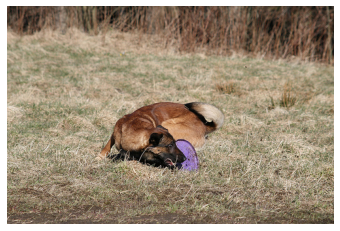

A brown dog waits for the Frisbee to come down before catching it.
A dog running in a park with a rubber chicken in its mouth.
A brown dog frolics in a field carrying a plush toy
A big black poodle running on the grass with a toy in its mouth.
A dog runs on the green grass near a wooden fence.


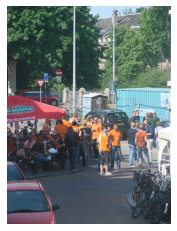

Travelers with lots of luggage standing in the middle of a large, empty city area.
People are driving scooters down the street at night.
There are a crowd of people standing on the side of the road with two cars beside them.
Two African american females ride on a moped down a city street that appears to be in a well congested area of a large city area.
Cars driving down a street lined with ornate walls and power lines.


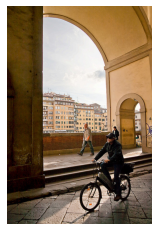

Two people on a bicycle are posing for a picture
Bicyclers riding over a bridge on a sunny day
A gentleman is riding his bike in the city.
A man on a bicycle pedals through an archway.
Four people are riding bicycles on a bike path near a busy street.


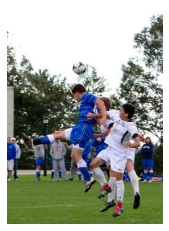

Two dirty guys playing soccer in the grass with players in the background.
Two boys practicing passing a soccer ball.
Three woman bouncing on balls in the grass.
Two males from the green team tackles the other members from black team for the ball in a game of rugby.
Three players bring a team opponent to the ground.


In [58]:
from PIL import Image
dataset_path = data_path / 'imgs'
query_images = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900]
img_out = "./results/task_d/retrieval"
for index in query_images:
    img_info = test_data[index]
    filename = img_info['filename']
    img= Image.open(dataset_path / filename)
    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()
    for i in range(5):
        j = neighbors[index][i]
        img_id = j//5
        text_id = j%5
        text = test_data[img_id]['sentences'][text_id]['raw']
        print(text)
        
    